In [1]:
import numpy as np
import matplotlib.pyplot as plt
import casadi.casadi as cs
import scipy.stats as stats

np.random.seed(37)

**See first:** [Kalman filter](./2_kalman_basic.ipynb)

In [2]:
# This is a useful function: it plots contours of the pdf of the 2D normal distribution
def plot_2d_normal_pdf(mu, cov, alpha=1):
    dx1 = 3.5 * np.sqrt(cov[0, 0])
    dx2 = 3.5 * np.sqrt(cov[1, 1])
    x, y = np.mgrid[mu[0]-dx1:mu[0]+dx1:.05, mu[1]-dx2:mu[1]+dx2:.05]
    pos = np.dstack((x, y))
    z = stats.multivariate_normal.pdf(pos, mu, cov)
    plt.contour(x, y, z, levels=10, alpha=alpha)

## Jacobian matrix

Consider a function $f:{\rm I\!R}^n\to{\rm I\!R}^m$. This can be written as $f(x) = (f_1(x), \ldots, f_m(x)).$
The **Jacobian matrix** of $f$ at a point $x\in {\rm I\!R}^n$ is the matrix
$$Jf(x) = \begin{bmatrix}
    \tfrac{\partial f_1(x)}{\partial x_1} & \tfrac{\partial f_1(x)}{\partial x_2} & \cdots & \tfrac{\partial f_1(x)}{\partial x_n}
    \\
    \vdots                                & \vdots                                & \ddots & \vdots
    \\
    \tfrac{\partial f_m(x)}{\partial x_1} & \tfrac{\partial f_m(x)}{\partial x_2} & \cdots & \tfrac{\partial f_m(x)}{\partial x_n}
\end{bmatrix}.$$
We can use the Jacobian matrix to linearise a *continuously differentiable* function $f$. From Taylor's Theorem,
$$f(x) \approx f(x_0) + Jf(x_0) (x - x_0),$$
for $x$ close to $x_0$.

### Example 1 (Manual)

Consider the function $f:{\rm I\!R}^3\to{\rm I\!R}^2$ given by
$$f(x) = \begin{bmatrix}x_1x_2x_3 \\ \sin(x_1)e^{x_2} \\ 1 - x_3^2 \end{bmatrix}.$$
Then,
$$Jf(x)=\begin{bmatrix}
\tfrac{\partial [x_1x_2x_3]}{\partial x_1} & \tfrac{\partial [x_1x_2x_3]}{\partial x_2} & \tfrac{\partial [x_1x_2x_3]}{\partial x_3}
\\
\tfrac{\partial [\sin(x_1)e^{x_2}]}{\partial x_1} & \tfrac{\partial [\sin(x_1)e^{x_2}]}{\partial x_2} & \tfrac{\partial [\sin(x_1)e^{x_2}]}{\partial x_3}
\\
\tfrac{\partial [1 - x_3^2]}{\partial x_1} & \tfrac{\partial [1 - x_3^2]}{\partial x_2} & \tfrac{\partial [1 - x_3^2]}{\partial x_3} \end{bmatrix}.$$
From this, we have
$$Jf(x) = \begin{bmatrix} x_2x_3 & x_1x_3 & x_2x_3 \\ \cos(x_1)e^{x_2} & \sin(x_1)e^{x_2} & 0 \\ 0 & 0 & -2x_3 \end{bmatrix}.$$

### Example 2 (Automatic)

We will determine the Jacobian of the same function in Python using `casadi` — a symbolic differentiation framework.


In [3]:
x = cs.SX.sym('x', 3) # define symbolic variable
# define function f using cs.vertcat
f = cs.vertcat(x[0]*x[1]*x[2],
               cs.sin(x[0]) * cs.exp(x[1]),
               1 - x[2]**2)
# compute Jacobian matrix of f with automatic differentiation
jf = cs.jacobian(f, x)
# create a Function object
jf = cs.Function('jf', [x], [jf])
# call the Jacobian matrix
v = jf([1, -4, 1])
print(np.array(v))

[[-4.          1.         -4.        ]
 [ 0.00989598  0.01541208  0.        ]
 [ 0.          0.         -2.        ]]


**Note:** We often don't need to compute the whole Jacobian matrix, but products of the form $Jf(x)\cdot d$, for given points $x$ and $d$. This can be done more efficiently using `jtimes`. You can find an example [here](https://web.casadi.org/docs/#syntax).

## Linearisation

Suppose $X$ is a random variable (vector-valued) and we want to determine ${\rm I\!E}[f(X)]$ and ${\rm Var}[f(X)]$, where $f:{\rm I\!R}^n \to {\rm I\!R}^m$ is a nonlinear continuous differentiable function. From Taylor's theorem using $X_0 = {\rm I\!E}[X]$, we have
$$f(x) \approx f(x_0) + Jf(x) (x - x_0),$$
for $x$ close to $x_0$. We can then consider the approximation
$${\rm I\!E}[f(X)] \approx {\rm I\!E}[f(X_0) + Jf(X_0) (X - X_0)] = f(X_0),$$
and
$${\rm Var}[f(X)] \approx {\rm Var}[f(X_0) + Jf(X_0) (X-X_0)] = Jf(X_0) {\rm Var}[X] Jf(X_0)^\intercal.$$

### Example in 1D

Suppose $X\sim\mathcal{N}(\mu, \sigma^2)$. We want to approximate the expectation and variance of $Y = e^X$.

**Spoilers:**  The correct values are ${\rm I\!E}[Y] = e^{\mu + \sigma^2/2}$ and ${\rm Var}[Y] = (e^{\sigma^2}-1)e^{2\mu+\sigma^2}$.

**Jacobian:** Here $f(x) = e^x$. The derivative of $f$ is $f'(x) = e^x$.

**Linearisation:** The approximation of the expectation of $Y$ is
$${\rm I\!E}[Y] \approx e^{\mu},$$
and the approximation of the variance is
 $${\rm Var}[Y] \approx f(\mu)^2 \sigma^2 = e^{2\mu}\sigma^2.$$
 Let us assess how good this approximation is.

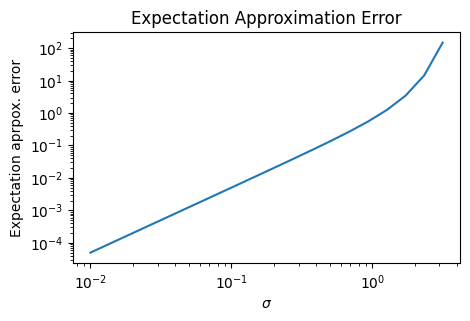

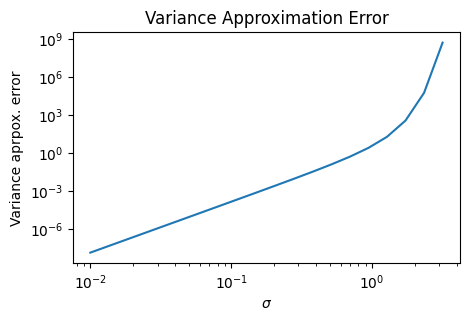

In [4]:
mu = 0
n_points = 20
sigmas = np.logspace(-2, 0.5, n_points)
expectations_true = np.exp(mu + 0.5 * sigmas**2)
expectation_lin = np.exp(mu)
variances_true = (np.exp(sigmas**2) - 1) * np.exp(2*mu + sigmas**2)
variances_lin = np.exp(2*mu) * sigmas**2

err_var = np.abs(variances_true - variances_lin)
err_exp = np.abs(expectations_true - expectation_lin)

plt.figure(figsize=(5, 3))
plt.loglog(sigmas, err_exp)
plt.xlabel('$\\sigma$')
plt.ylabel('Expectation aprpox. error')
plt.title('Expectation Approximation Error')
plt.show()

plt.figure(figsize=(5, 3))
plt.loglog(sigmas, err_var)
plt.xlabel('$\\sigma$')
plt.ylabel('Variance aprpox. error')
plt.title('Variance Approximation Error')
plt.show()

We see that the approximation is good only at low variances.

## Extended Kalman Filter

### Nonlinear model

Consider the following nonlinear system
$$\begin{align*}
    x_{t+1} {}={} & f(x_t, w_t),
    \\
    y_t {}={}     & h(x_t, v_t),
\end{align*}$$
where $x_0$, $(w_t)_t$ and $(v_t)_t$ are independent, $(w_t)_t$ and $(v_t)_t$ have zero mean and covariance matrices $Q$ and $R$ respectively. Even if $w$ and $v$ are Gaussian, $x_t$ and $y_t$ may not be (and typically are not).

The objective is to determine $\hat{x}_{t+1{}\mid{}t}$, $\hat{x}_{t{}\mid{}t}$ and the corresponding covariance matrices.

The extended Kalman filter (EKF) is based on the Kalman filter. The idea is to approximate all expectations and variances using the linearisation trick (see previous section).


### Measurement update

Initialisation: $\hat{x}_{0{}\mid{}-1}{}={}\tilde{x}_0$ and $\Sigma_{0{}\mid{}-1}{}={}P_0$.

Linearise the output function at $x=\hat{x}_{t{}\mid{}t-1}$:
$$\begin{align*}
    C {}={}             & J_x h(\hat{x}_{t{}\mid{}t-1}, 0),
    \\
    \widetilde{R} {}={} & J_v  h (\hat{x}_{t{}\mid{}t-1}, 0) \, R\, J_v  h (\hat{x}_{t{}\mid{}t-1}, 0)^\intercal
\end{align*}$$
The measurement update is
$$\begin{align*}
    \hat{x}_{t{}\mid{}t}
    {}={} &
    \hat{x}_{t{}\mid{}t-1}
    {}+{}
    \Sigma_{t{}\mid{}t-1}C^\intercal
    (C\Sigma_{t{}\mid{}t-1}C^\intercal + \widetilde{R})^{-1}(y_t - h(x_{t\mid t-1}, 0))
    \\
    \Sigma_{t{}\mid{}t}
    {}={} &
    \Sigma_{t{}\mid{}t-1}
    {}-{}
    \Sigma_{t{}\mid{}t-1}C^\intercal
    (C\Sigma_{t{}\mid{}t-1}C^\intercal + \widetilde{R})^{-1}
    C\Sigma_{t{}\mid{}t-1}
\end{align*}$$

### Time update

Linearise the dynamics at $x=\hat{x}_{t\mid t}$
$$\begin{align*}
    A {}={}             & J_x f(\hat{x}_{t{}\mid{}t}, 0),
    \\
    \widetilde{Q} {}={} & J_w f(\hat{x}_{t{}\mid{}t}, 0) \, Q\, J_w f(\hat{x}_{t{}\mid{}t}, 0)^\intercal
\end{align*}$$
The time update is
$$\begin{align*}
    \hat{x}_{t+1\mid t} {}={} & f(\hat{x}_{t\mid t}, 0),
    \\
    \Sigma_{t+1 \mid t} {}={} & A\Sigma_{t \mid t}A^\intercal + \widetilde{Q}.
\end{align*}$$

## EKF in Action

### Navigation example

Let $r_t,u_t,a_t\in{\rm I\!R}^2$ be the (planar) position, velocity and acceleration of a vehicle with dynamics
$$\begin{align*}
        r_{t+1} {}={} & r_{t} + 0.2 u_t,
        \\
        u_{t+1} {}={} & u_t + 0.2 a_t,
        \\
        a_{t+1} {}={} & \Phi a_{t} + w_t,
\end{align*}$$
where $w_t \sim \mathcal{N}(0_2, 0.2I_2)$, and
$$\begin{equation*}
        \Phi {}={}
        \begin{bmatrix}
            \phantom{-}0.50 & 0.87
            \\
            -0.87           & 0.48
        \end{bmatrix}.
\end{equation*}$$
Three beacons are positioned at $r^{(1)} = (3, 2)$, $r^{(2)}=(2, -3)$ and $r^{(3)}=(-5, 3)$; a sensor can measure the distances to these points — in particular
$$\begin{equation*}
        y_{i, t}
        {}={}
        \|r - r^{(i)}\|_2 + v_{i,t},\ i\in{\rm I\!N}_{[1,3]},
\end{equation*}$$
where $v_{i,t} \sim \mathcal{N}(0, 4)$

We have a system with state vector $z_t = (r_t, u_t, a_t)$ and output $y_t$. The dynamics is linear
$$\begin{equation*}
        z_{t+1} = \begin{bmatrix}
            I_2 & 0.2I_2
            \\
                & I_2    & 0.2I_2
            \\
                &        & \Phi
        \end{bmatrix}
        x_{t}
        +
        \begin{bmatrix}
            0_{4\times 2}
            \\
            I_2
        \end{bmatrix}
        w_t,
\end{equation*}$$
but the output equation is nonlinear, $y_t {}={} h(z_t, v_t)$.

Let us implement this EKF. We will start by defining the problem data

In [5]:
# Problem data
Phi = np.array([[0.5, 0.87], [-0.87, 0.48]])
anchors = np.array([[3, 2], [2, -3], [-5, -3]])
ny = len(anchors)
nx = 6
Q = np.array([[0.02, 0], [0, 0.02]])
R = 0.05*np.eye(ny)

A = np.block([[np.eye(2), 0.2*np.eye(2), np.zeros((2, 2))],
              [np.zeros((2, 2)), np.eye(2), 0.2*np.eye(2)],
              [np.zeros((2, 4)), Phi]])
Qbar = np.block([[np.zeros((4, 6))], [np.zeros((2, 4)), Q]])

Let us now create the system dynamics, $f$, the output function, $h$, and the Jacobians of $h$ (wrt $x$ and $v$)

In [6]:
# System dynamics
def f(x, w):
    x_plus = A @ x
    x_plus[4:6] += w
    return x_plus

# Create function h(z, v) using casadi
z_ = cs.SX.sym('z_', nx)
v_ = cs.SX.sym('v_', ny)
r_ = z_[0:2]
h_ = cs.vertcat( *[cs.norm_2(r_ - anchors[i]) + v_[i] for i in range(ny) ] )

# Determination of the Jacobian matrix of h
jhx = cs.jacobian(h_, z_)
jhv = cs.jacobian(h_, v_)
jhx = cs.Function('jhx', [z_, v_], [jhx])
jhv = cs.Function('jhv', [z_, v_], [jhv])

# Create a Function object for h
h = cs.Function('h', [z_, v_], [h_])

Let us now run some simulations with the EKF

In [7]:
x_t = np.array([0.5, 0.1, 1, 0, 0, 0])
x_t_pred = np.zeros(nx, )
sigma_t_pred = 10*np.eye(nx)

N = 100

def measurement_update(sigma_t_pred, x_t_pred, y_t):
    C = jhx(x_t_pred, 0)
    Z = C @ sigma_t_pred @ C.T + R
    x_t_meas = x_t_pred + sigma_t_pred @ C.T @ np.linalg.solve(Z, y_t - h(x_t_pred, [0]*ny))
    sigma_t_meas = sigma_t_pred - sigma_t_pred @ C.T @ np.linalg.solve(Z, C @ sigma_t_pred)
    return np.array(sigma_t_meas), np.array(x_t_meas)

def time_update(sigma_t_meas, x_t_meas):
    x_t_pred = f(x_t_meas, np.zeros((2, 1)))
    sigma_t_pred = A @ sigma_t_meas @ A.T + Qbar
    return np.array(sigma_t_pred), np.array(x_t_pred)

x_cache = np.zeros((N, nx))
x_meas_cache = np.zeros((N-1, nx))
sigma_meas_cache = np.zeros((N-1, nx, nx))
x_cache[0, :] = x_t.T

for t in range(N-1):
    # i. obtain measurement
    v_t = np.random.multivariate_normal([0]*ny, R)
    y_t = h(x_t, v_t)

    # ii. measurement update
    sigma_t_meas, x_t_meas = measurement_update(sigma_t_pred, x_t_pred, y_t)
    x_meas_cache[t, :] =  x_t_meas.T
    sigma_meas_cache[t, :, :] = sigma_t_meas

    # iii. Time update
    sigma_t_pred, x_t_pred = time_update(sigma_t_meas, x_t_meas)

    # iv. Dynamics
    w_t = np.random.multivariate_normal([0, 0], Q)
    x_t = f(x_t, w_t)
    x_cache[t + 1, :] = x_t.T

Plots...

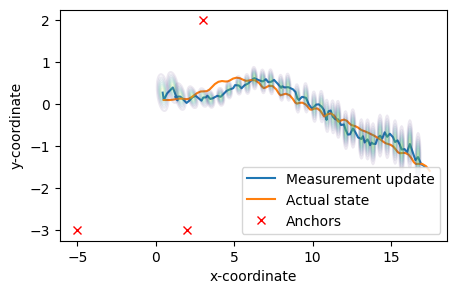

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(x_meas_cache[:, 0], x_meas_cache[:, 1], label='Measurement update')
plt.plot(x_cache[:, 0], x_cache[:, 1], label='Actual state')
for i in range(ny):
    plt.plot(anchors[i, 0], anchors[i, 1], 'rx', label='Anchors' if i==0 else None)

for t in range(0,N-1,3):
    plot_2d_normal_pdf(x_meas_cache[t, :2], sigma_meas_cache[t, :2, :2], alpha=0.1)

plt.legend()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()

The figure above shows the actual and estimated position of the vehicle. The contours correspond to the distribution $\mathcal{N}(\hat{x}_{t\mid t}, \Sigma_{t\mid t})$.

## Intermittent measurements

Suppose the connection to the GPS is lost for some time. Then we can apply *time updates* only. Of course this will have an impact on the estimation error.

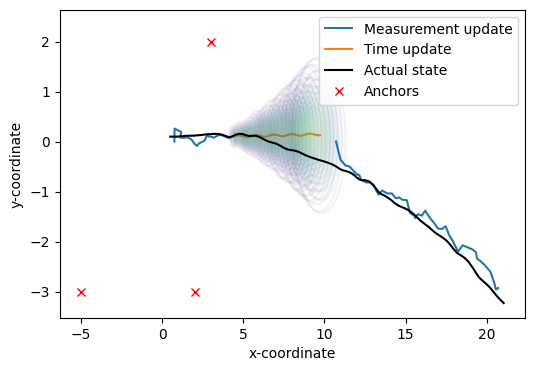

In [9]:
x_t = np.array([0.5, 0.1, 1, 0, 0, 0])
x_t_pred = np.zeros(nx, )
sigma_t_pred = 10*np.eye(nx)

N = 100

x_cache = np.zeros((N, nx))
x_meas_cache = np.zeros((N-1, nx))
sigma_meas_cache = np.zeros((N-1, nx, nx))
x_tu_cache = np.zeros((N, nx))
sigma_tu_cache = np.zeros((N, nx, nx))

x_cache[0, :] = x_t.T
x_tu_cache[0, :] = x_t_pred.T
sigma_tu_cache[0, :, :] = sigma_t_pred

disruption_times = np.arange(20, 50)

for t in range(N-1):
    # i. obtain measurement
    v_t = np.random.multivariate_normal([0]*ny, R)
    y_t = h(x_t, v_t)

    # ii. measurement update
    if not t in disruption_times:
        sigma_t_meas, x_t_meas = measurement_update(sigma_t_pred, x_t_pred, y_t)
        x_meas_cache[t, :] =  x_t_meas.T
        sigma_meas_cache[t, :, :] = sigma_t_meas
    else:
        x_meas_cache[t, :] = np.nan
        x_t_meas = x_t_pred
        sigma_t_meas = sigma_t_pred

    # iii. Time update
    sigma_t_pred, x_t_pred = time_update(sigma_t_meas, x_t_meas)
    x_tu_cache[t+1, :] = x_t_pred.T
    sigma_tu_cache[t+1, :, :] = sigma_t_meas

    # iv. Dynamics
    w_t = np.random.multivariate_normal([0, 0], Q)
    x_t = f(x_t, w_t)
    x_cache[t + 1, :] = x_t.T

plt.figure(figsize=(6, 4))
plt.plot(x_meas_cache[:, 0], x_meas_cache[:, 1], label='Measurement update')
plt.plot(x_tu_cache[disruption_times, 0], x_tu_cache[disruption_times, 1], label='Time update')
for tau in disruption_times:
    plot_2d_normal_pdf(x_tu_cache[tau, :2], sigma_tu_cache[tau, :2, :2], alpha=0.06)
plt.plot(x_cache[:, 0], x_cache[:, 1], 'k', label='Actual state')
for i in range(ny):
    plt.plot(anchors[i, 0], anchors[i, 1], 'rx', label='Anchors' if i==0 else None)

plt.legend()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()

## Application to Chemical Reactor

**Taken from:** E.L. Haseltine & J.B. Rawlings, A Critical Evaluation of Extended Kalman Filtering and Moving Horizon Estimation, *Ind. Eng. Chem. Res.* 2005, 44(8):2451-60.

Consider the following chemical reaction take takes place in gaseous phase
$$
2A {}\longrightarrow{} B,
$$
with rate coefficient $k=0.16$ and reaction rate $r=kP_A^2$, where $P_A$ and $P_B$ are the \textit{partial pressures} of $A$ and $B$ respectively. The state is the vector $x=[P_A ~ P_B]^\intercal$ and the system dynamics is
$$
x_{t+1} =
\underbrace{\begin{bmatrix}
    \frac{x_{t, 1}}{2k\Delta t x_{t, 1} + 1}
    \\
    x_{t, 2} + \frac{k \Delta t x_{t, 1}^2}{2k\Delta t x_{t, 1} + 1}
  \end{bmatrix}}_{F(x_t)} + w_t,
$$
where $\Delta t = 0.1$ is the sampling time. We can measure the total pressure, that is
$$y_t = \begin{bmatrix}
  1 & 1
\end{bmatrix}x_t + v_t,$$
where $v_t\sim\mathcal{N}(0, 0.1^2)$ ($R=0.1^2$) and $w_t \sim \mathcal{N}(0, 0.001^2 I_2)$ ($Q=0.001^2 I_2$).

Suppose that $x_0 = [3 ~ 1]^\intercal$ while our prior knowledge about $x_0$ is $\bar{x}_0 = [3.1 ~ 1.1]^\intercal$ and $P_0 = 6^2 I_2$.

In [10]:
# Constants
k, dt = 0.16, 0.1
nx, ny = 2, 1
C = np.array([[1, 1]])

# Function F and its Jacobian matrix
x_ = cs.SX.sym('x_', nx)
f_ = cs.vertcat( x_[0] / (2 * k * dt * x_[0] + 1),
                 x_[1] + (k * dt * x_[0]**2) / (2 * k * dt * x_[0] + 1))
jfx_ = cs.jacobian(f_, x_)
F = cs.Function('f', [x_], [f_])
JFx = cs.Function('f', [x_], [jfx_])

# Covariances
R = 0.1**2
Q = 0.001**2 * np.eye(2)
P0 = 6**2 * np.eye(2)
x_t_pred = np.array([[3.1, 1.1]]).T
x_t = np.array([[3, 1]]).T

Let us now perform simulations with EKF. Firstly, we need to define the functions `measurement_update` and `time_update`.

In [11]:
def measurement_update(sigma_t_pred, x_t_pred, y_t):
    Z = C @ sigma_t_pred @ C.T + R
    x_t_meas = x_t_pred + sigma_t_pred @ C.T @ np.linalg.solve(Z, y_t - C @ x_t_pred)
    sigma_t_meas = sigma_t_pred - sigma_t_pred @ C.T @ np.linalg.solve(Z, C @ sigma_t_pred)
    return np.array(sigma_t_meas), np.array(x_t_meas)

def time_update(sigma_t_meas, x_t_meas):
    A = JFx(x_t_meas)
    x_t_pred = F(x_t_meas)
    sigma_t_pred = A @ sigma_t_meas @ A.T + Q
    return np.array(sigma_t_pred), np.array(x_t_pred)

Now we can perform the simulations with EKF

In [12]:
N = 50

sigma_t_pred = P0
x_cache = np.zeros((N, nx))
x_meas_cache = np.zeros((N-1, nx))
sigma_meas_cache = np.zeros((N-1, nx, nx))
x_cache[0, :] = x_t.T

for t in range(N-1):
    # i. obtain measurement
    v_t = np.random.multivariate_normal([0]*ny, [[R]])
    y_t = C @ x_t + v_t

    # ii. measurement update
    sigma_t_meas, x_t_meas = measurement_update(sigma_t_pred, x_t_pred, y_t)
    x_meas_cache[t, :] =  x_t_meas.T
    sigma_meas_cache[t, :, :] = sigma_t_meas

    # iii. Time update
    sigma_t_pred, x_t_pred = time_update(sigma_t_meas, x_t_meas)

    # iv. Dynamics
    w_t = np.random.multivariate_normal([0, 0], Q)
    x_t = F(x_t) + w_t
    x_cache[t + 1, :] = x_t.T

and we can plot the results...

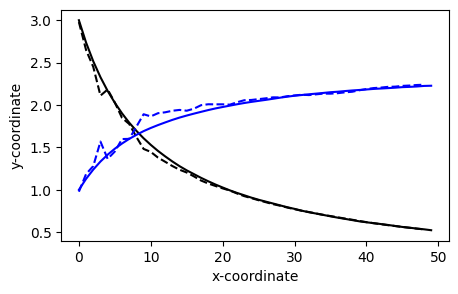

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(x_meas_cache[:, 0], 'k--')
plt.plot(x_cache[:, 0], 'k')
plt.plot(x_meas_cache[:, 1], 'b--')
plt.plot(x_cache[:, 1], 'b')

plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()

The EKF seems to work fairly well. However, we deliberately took $\tilde{x}_0$ to be very close to $x_0$ (note that $x_0$ is *unknown*).

**Exercise:** Repeat the above simulation using $\tilde{x}_0 = [0.1 ~ 4.5]^\intercal$. You should see that the EKF performs very poorly! You will also see that the estimates of one of the partial pressures become negative (which doesn't make physical sense).

**Exercise:** Plot the state error $e_{t\mid t} = x_{t} - \hat{x}_{t\mid t}$ and the output error $e^y_{t\mid t} = y_t - C\hat{x}_{t\mid t}$.

**Conclusion:** Sometimes it works, sometimes it doesn't!

**See next:** [Tutorial](./6_tutorial.ipynb)